# Axis 1: Somme study about 

In [14]:
import sys
import pickle

from pathlib import Path
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt



## Initialisations

In [3]:
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

print(f"Root folder detected at: {root}")

# Ensure importability of the project
if str(root) not in sys.path:
    sys.path.insert(0, str(root))



Root folder detected at: /Users/43rt1k/Documents/EPFL/_MASTER/ADA/ADAcore42


In [4]:
from src.utils.paths import STORED_DATAPREP_PKL_PATH, STORED_PLOTSGUI_PKL_PATH, DATA_PREPARATION_PY_PATH, STORED_DATAPREPNOUNS_PKL_PATH, STORED_DATAPREPTOKENS_PKL_PATH, OCCUPATIONS_CSV_PATH
print(root / DATA_PREPARATION_PY_PATH) #If works: ...../ADAcore42/src/data/DataPreparation.py

/Users/43rt1k/Documents/EPFL/_MASTER/ADA/ADAcore42/src/data/DataPreparation.py


In [5]:
# %run {root / DATA_PREPARATION_PY_PATH}

In [6]:
# Pickle datapreprocessed file loading
with open(root / STORED_DATAPREP_PKL_PATH, "rb") as f:
    data = pickle.load(f)

# Objects extraction
dataA = data['dataA']
dataC = data['dataC']
dataA_startID = data['dataA_startID']
dataA_endID = data['dataA_endID']
dataC_lastGoodID = data['dataC_lastGoodID']
dataA[0]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
rank,,,,,,,,
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,10.03
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,8.22
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,6.55
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,6.08
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,4.74
...,...,...,...,...,...,...,...,...
3900,"Just getting material for my book, "" Humanity ...",1.000000,0.117851,9,9,0,0,-0.80
3901,This has 'Alice in Wonderland' beat by a mile.,1.000000,0.117851,9,9,0,0,-0.80
3902,I could use a quick pick-me-up.,1.000000,0.117851,9,9,0,0,-0.80


# 1. How does the votes nb influence the caption rating?

In [7]:
vote_cols = ['not_funny', 'somewhat_funny', 'funny', 'votes', 'funny_score']
funny_cols = ['not_funny', 'somewhat_funny', 'funny']
dataA[0]

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score
rank,,,,,,,,
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,10.03
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,8.22
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,6.55
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,6.08
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,4.74
...,...,...,...,...,...,...,...,...
3900,"Just getting material for my book, "" Humanity ...",1.000000,0.117851,9,9,0,0,-0.80
3901,This has 'Alice in Wonderland' beat by a mile.,1.000000,0.117851,9,9,0,0,-0.80
3902,I could use a quick pick-me-up.,1.000000,0.117851,9,9,0,0,-0.80


As vote number reference lets take the winning caption with the smallest votes number

In [8]:
minnestVotes = 1000000

for idx, df in enumerate(dataA):
    best3 = df.head(1)
    minVotes = best3['votes'].min()

    if minVotes < minnestVotes: minnestVotes = minVotes

print("The smallest votes number of the winning caption: ", minnestVotes)

The smallest votes number of the winning caption:  9


### 1. How does the populyrity(number of votes) of a caption correlate with captions rank

In [9]:
#Stick all captions together
dataAm = pd.concat(dataA, ignore_index=True)
#Keep only vote related cols
dataAm = dataAm[vote_cols]
#Sort by vote nb
dataAm.sort_values(by="votes", ascending=True, inplace=True)
dataAm.reset_index(drop=True, inplace = True)

#Remove captions with less than minnest votes 
dataAm = dataAm[dataAm['votes'] >= minnestVotes]

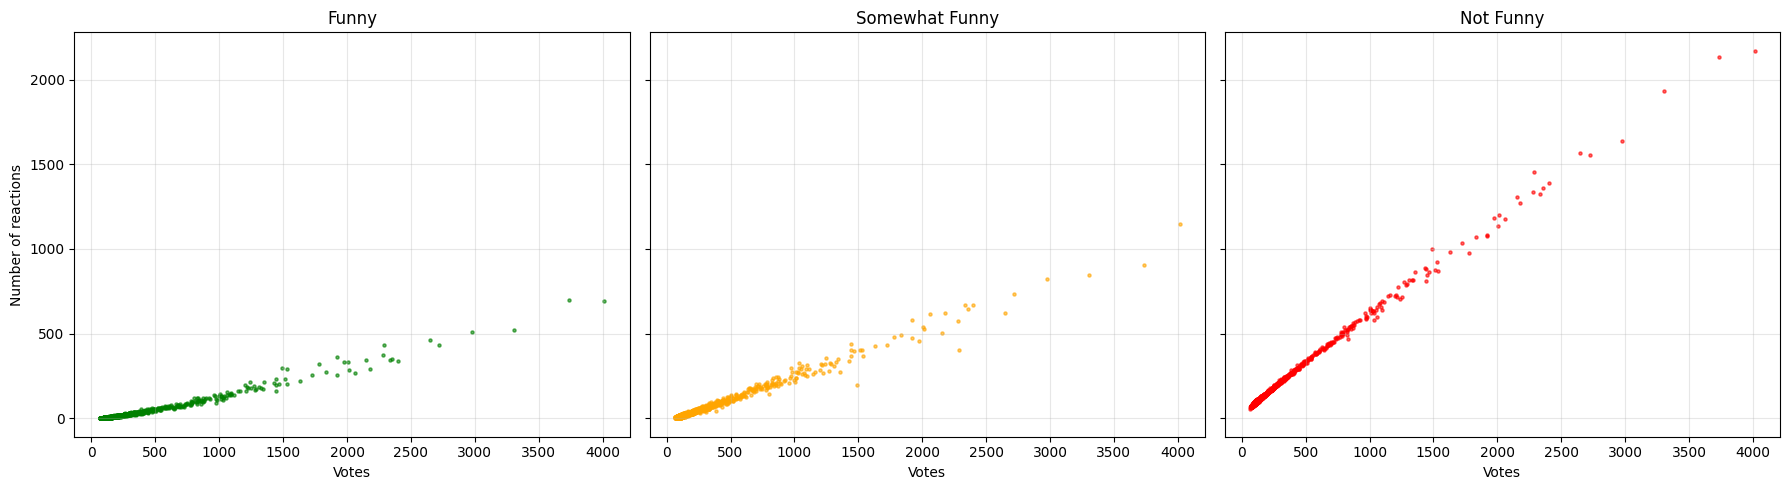

In [10]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

plots = [
    ('funny', 'green'),
    ('somewhat_funny', 'orange'),
    ('not_funny', 'red'),
]

for ax, (col, color) in zip(axes, plots):
    ax.scatter(df['votes'], df[col], s=5, alpha=0.6, color=color)
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel("Votes")
    ax.grid(True, alpha=0.3)


axes[0].set_ylabel("Number of reactions")


plt.tight_layout()
plt.show()

From this we can conclude: 
- The evaluation (++, +, -) grows with the vote number, but differently
- The grow is approximatively linear, thus can be approximated

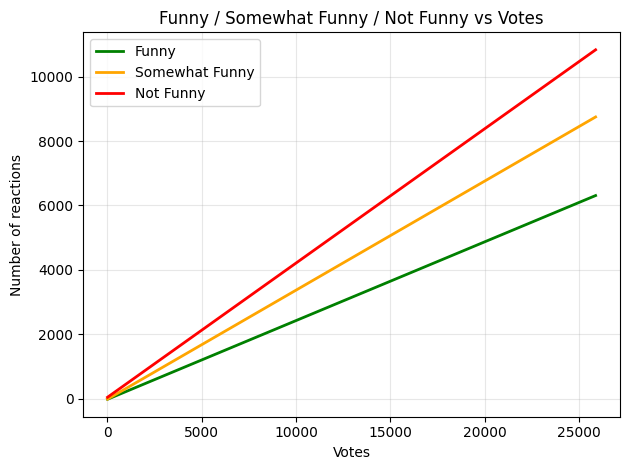

In [11]:
features = [
    ("funny", "green"),
    ("somewhat_funny", "orange"),
    ("not_funny", "red"),
]

X = dataAm[["votes"]].values
x_line = np.linspace(dataAm["votes"].min(), dataAm["votes"].max(), 500).reshape(-1, 1)

for col, color in features:
    y = dataAm[col].values

    # Fit regression model
    model = LinearRegression()
    model.fit(X, y)
    y_line = model.predict(x_line)

    # Plot only the regression line
    plt.plot(x_line, y_line, color=color, linewidth=2, label=col.replace("_", " ").title())

plt.xlabel("Votes")
plt.ylabel("Number of reactions")
plt.title("Funny / Somewhat Funny / Not Funny vs Votes")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

When i began working on this, i was expecting the opposite result: more the caption is popular, more ++/+ votes it will have. What about the funny score? 


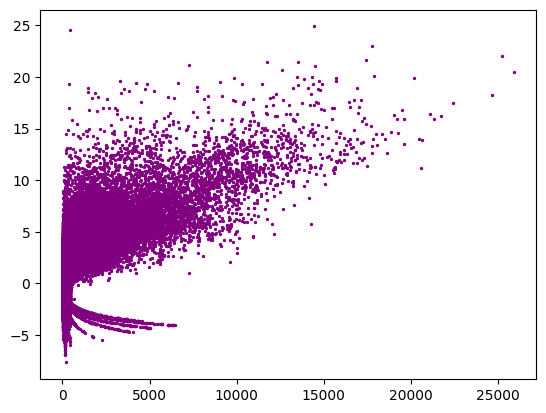

In [24]:
plt.scatter(dataAm['votes'], dataAm['funny_score'], s=2, c="purple")
plt.show()

Here we can see, that looking at votes number is impossible to predict if the caption will be the funniest, but we clearly see that more the caption is popular, more is probable that the caption will have a certain minimal rank. 

In [17]:
X = dataAm["votes"].values.reshape(-1, 1)
y = dataAm["funny_score"].values

# Add intercept
X_q = sm.add_constant(X)

# Quantile regression for lower bound (5th percentile)
quantile = 0.05
model = sm.QuantReg(y, X_q)
res = model.fit(q=quantile)

# Create prediction line
x_line = np.linspace(X.min(), X.max(), 500)
X_line = sm.add_constant(x_line)
y_line = res.predict(X_line)

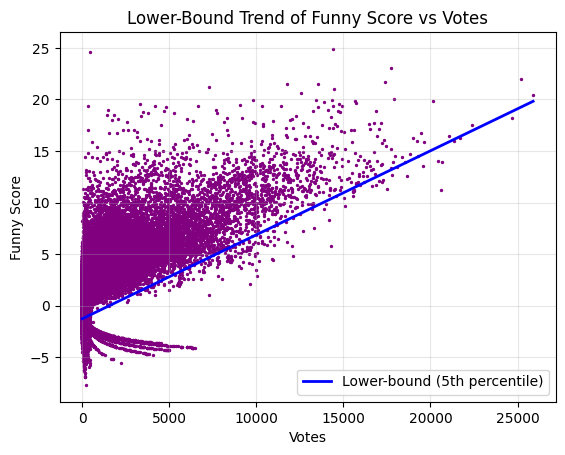

In [23]:
plt.scatter(X, y, s=2, color="purple")
plt.plot(x_line, y_line, color="blue", linewidth=2, label="Lower-bound (5th percentile)")
plt.xlabel("Votes")
plt.ylabel("Funny Score")
plt.title("Lower-Bound Trend of Funny Score vs Votes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

It is obviously not the number of votes itself which gives a good rating to a caption, but the consequence of being a good caption makes it more and more popular (in other words: the funnier is the capton, more popular it will be).

# 2. Estimating the image funiness vs caption evaluation